## Check how many neurIPS papers are from 1987 to 2019 (After 2019 they don't have public meta-data)

In [4]:
import json
import os

def count_texts_in_jsonl_files(folder_path):
    total_texts = 0

    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jsonl'):
            file_path = os.path.join(folder_path, file_name)

            # Open and read the JSONL file
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    try:
                        # Attempt to load each line as a JSON object
                        json.loads(line)
                        total_texts += 1
                    except json.JSONDecodeError:
                        # Skip the line if it's not a valid JSON object
                        continue

    return total_texts

# Specify the path to the folder containing your JSONL files
input_folder_path = 'src/data/'

# Count the number of texts
num_texts = count_texts_in_jsonl_files(input_folder_path)
print(f"Total number of texts in JSONL files: {num_texts}")


Total number of texts in JSONL files: 9680


## Now we start the keyword search

### Importing needed libraries

In [1]:
import sys
sys.path.append('regex')
from regex_definitions import compiled_auroc_regex, compiled_auprc_regex

In [2]:
# Importing necessary functions and keyword lists
import sys
sys.path.append('src')  # Ensure the 'src' folder is in the Python path
from arxiv_search_regex import jsonl_folder_filtering

### Running search

In [5]:
# Specify the path to the folder containing your JSONL files
input_folder_path = 'data/neurIPS/'
output_folder_path = 'data'
metadata_keys = ['source_id', 'year', 'title', 'abstract']
# Call the jsonl_folder_filtering function

filename="neurIPS_filter_auc.csv"
total_texts_filename="total_texts_neurIPS.txt"

In [6]:
df_output_neurips = jsonl_folder_filtering(
    input_folder_path=input_folder_path,
    auroc_regex=compiled_auroc_regex,
    auprc_regex=compiled_auprc_regex,
    metadata_keys=metadata_keys,
    output_folder_path=output_folder_path,
    remove_latex=True,
    save_file=True,
    filename=filename,  # Changed to .csv for clarity
    total_texts_filename=total_texts_filename
)

In [9]:
df_output_neurips.to_csv("data/neurIPS_filter_auc.csv'", index=False)

/var/folders/rm/48r5vtns6fz6xtmhbq04sd7d03b5vb/T/ipykernel_82847/3565182958.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df_output_neurips.resample('Y', on='year').agg({'contains_auroc': 'sum', 'contains_auprc': 'sum'})
/var/folders/rm/48r5vtns6fz6xtmhbq04sd7d03b5vb/T/ipykernel_82847/3565182958.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly['contains_both'] = df_output_neurips[(df_output_neurips['contains_auroc'] == True) & (df_output_neurips['contains_auprc'] == True)].resample('Y', on='year').size()


'figures/papers_over_time.png'

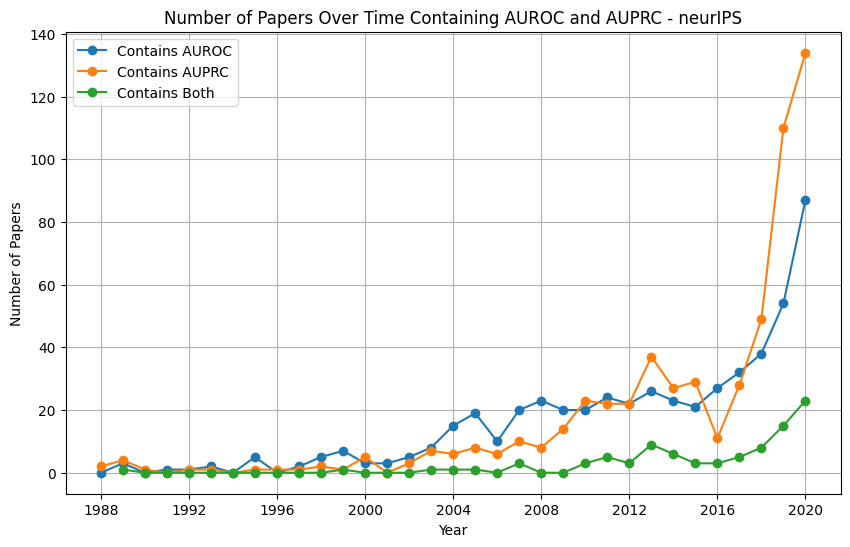

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os
# Convert timestamp to datetime
df_output_neurips['year'] = pd.to_datetime(df_output_neurips['year'])

# Resample data by year
df_yearly = df_output_neurips.resample('Y', on='year').agg({'contains_auroc': 'sum', 'contains_auprc': 'sum'})

# Calculate papers that contain both
df_yearly['contains_both'] = df_output_neurips[(df_output_neurips['contains_auroc'] == True) & (df_output_neurips['contains_auprc'] == True)].resample('Y', on='year').size()

# File path for the figure
figures_dir = "figures"
figure_path = os.path.join(figures_dir, 'papers_over_time.png')

# Save the figure
plt.figure(figsize=(10, 6))
plt.plot(df_yearly.index, df_yearly['contains_auroc'], label='Contains AUROC', marker='o')
plt.plot(df_yearly.index, df_yearly['contains_auprc'], label='Contains AUPRC', marker='o')
plt.plot(df_yearly.index, df_yearly['contains_both'], label='Contains Both', marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.title('Number of Papers Over Time Containing AUROC and AUPRC - neurIPS')
plt.legend()
plt.grid(True)
plt.savefig(figure_path)

figure_path

## Loading csv again and filtering for keyword inclusion

In [19]:
import pandas as pd
from tqdm import tqdm
import re

# Load data
df_output_neurips = pd.read_csv('data/neurIPS_filter_auc.csv')

# Filter rows
df_output_neurips_filtered = df_output_neurips[(df_output_neurips['contains_auroc'] == True) & (df_output_neurips['contains_auprc'] == True)]


In [20]:
len(df_output_neurips_filtered)

91

### Getting context window

In [22]:
# Importing necessary functions and keyword lists
import sys
sys.path.append('src')  # Ensure the 'src' folder is in the Python path

from claim_search_v3 import extract_context_windows_df
compiled_regexes = [compiled_auroc_regex, compiled_auprc_regex]

In [23]:
window_size = 200

df_output_neurips_filtered_context = extract_context_windows_df(df_output_neurips_filtered, 'text', [compiled_auroc_regex, compiled_auprc_regex], window_size=window_size)

In [ ]:
df_output_neurips_filtered_context['context_window'] = df_output_neurips_filtered_context['text']

### Saving data

In [29]:
df_output_neurips_filtered_context.to_csv('data/neurIPS_filtered_context.csv', index=False)

In [2]:
import pandas as pd
df_output_neurips_filtered_context = pd.read_csv('data/neurIPS_filtered_context.csv')

## GPT 4 Search

### Redefining systemt prompt, that does not have the last message from before. This is because we add such a description in the user prompt

In [3]:
SYSTEM_PROMPT = """
You are an expert in machine learning and scientific literature review.
For each chunk of a published paper (which may have typos, misspellings, and odd characters as a result of conversion from PDF), return a JSON object that states whether or not the paper makes any claim that the area under the precision recall curve (AUPRC) is superior or inferior as a general performance metric to the area under the receiver operating characteristic (AUROC) in an ML setting, in particular for imbalanced classification problems. A paper claiming that a model performs better under AUPRC vs. AUROC is *not* an example of this; instead a paper claiming that AUPRC should be used instead of AUROC in cases of class imbalance is an example of this metric commentary. Respond with format {"claims": [{"claim": DESCRIPTION OF CLAIM, "evidence_quote": SUBSTRING FROM INPUT STATING CLAIM}, ...]}. If the paper makes no claims, leave the "claims" key in the JSON object empty. If the claim made is that the AUPRC is superior to the AUROC in the case of class imbalance, use the string "AUPRC is superior to AUROC for imbalanced data" for the description of the claim. For other claims, use any appropriate free-text description.

Examples: 

Input: "AUROC: The horizontal and vertical coordinates of the Receiver Operating Characteristic (ROC) curve are the FPR and TPR, and the curve is obtained by calculating the FPR and TPR under multiple sets of thresholds. The area of the region enclosed by the ROC curve and the horizontal axis is often used to evaluate binary classification tasks, denoted as AUROC. The value of AUROC is within the range of [0, 1], and higher values indicate better performance. AUROC can visualize the generalization performance of the GVAED model and help to select the best alarm threshold In addition, the Equal Error Rate (EER), i.e., the proportion of incorrectly classified frames when TPR and FNR are equal, is also used to measure the performance of anomaly detection models. AP: Due to the highly unbalanced nature of positive and negative samples in GVAED tasks, i.e., the TN is usually larger than the TP, researchers think that the area under the Precision-Recall (PR) curve is more suitable for evaluating GVAED models, denoted as AP. The horizontal coordinates of the PR curve are the Recall (i.e., the TPR in Eq. 4), while the vertical coordinate represents the Precision, defined as Precision = TP TP+FP . A point on the PR curve corresponds to the Precision and Recall values at a certain threshold."
Output: {"claims": [{"claim": "AUPRC is superior to AUROC for imbalanced data", "evidence_quote": "Due to the highly unbalanced nature of positive and negative samples in GVAED tasks, i.e., the TN is usually larger than the TP, researchers think that the area under the Precision-Recall (PR) curve is more suitable for evaluating GVAED models, denoted as AP"}]}

Input: "As seen, it outperforms other approaches except in the cases of TinyImageNet for CIFAR-100. Our approach still has better AUROC, but the detection error and FPR at 95% TPR are slightly larger than ODIN’s. Interestingly, the MD approach is worse than max-softmax in some cases. Such a result has also been reporte"
Output: {"claims": []}

Input: "AUC-ROC measures the class separability at various threshold settings. ROC is the probability curve and AUC represents the degree of measures of separability. It compares true positive rate (sensitivity/recall) versus the false positive rate (1 - specificity). The higher the AUC-ROC, the bigger the distinction between the true positive and false negative. • AUC-PR: It combines the precision and recall, for various threshold values, it compares the positively predicted value (precision) vs the true positive rate (recall). Both precision and recall focus on the positive class (the lesion) and unconcerned about the true negative (not a lesion, which is the majority class). Thus, for class imbalance, PR is more suitable than ROC. The higher the AUC-PR, the better the model performance"
Output: {"claims": [{"claim": "AUPRC is superior to AUROC for imbalanced data", "evidence_quote": "Thus, for class imbalance, PR is more suitable than ROC"}]}
"""

### Defining introduction and end statement to the user prompt

In [4]:
introduction_statement_prompt = """
Please carefully review the following text. We are specifically looking for claims where AUPRC is argued to be a superior metric to AUROC, especially in cases of class imbalance in machine learning applications. Any claim that discusses the preference of AUPRC over AUROC due to its effectiveness in such scenarios should be returned in the a JSON object. If no such claims are found, please leave the 'claims' key empty. Here is the text:
"""
end_statement_prompt = """
If you find any claim asserting the superiority of AUPRC over AUROC for imbalanced datasets, please provide your findings in a JSON object with the key 'claims'. Each claim should be a dictionary with 'claim' and 'evidence_quote' as keys, like this: {"claims": [{"claim": "DESCRIPTION OF CLAIM", "evidence_quote": "SUBSTRING FROM INPUT STATING CLAIM"}]}. If no relevant claims are found, the 'claims' key should have an empty list.
"""

### Setting up environment

In [5]:
import sys
import os
sys.path.append('src')  # Adjust this path to ensure it points to the correct directory

from claim_search_v4 import process_all_context_windows

model = "gpt-4-0125-preview"
openai_api_key = "INSERT_YOUR_API_KEY"

In [6]:
df_claims_neurips = process_all_context_windows(df_output_neurips_filtered_context, model, SYSTEM_PROMPT, introduction_statement_prompt, end_statement_prompt, openai_api_key, texts_before_pause=500, pause_duration=0.5, max_workers=6)

# Save the updated DataFrame
df_claims_neurips.to_csv('data/processed_gpt_4_0_neurips.csv', index=False)

### Extracting claims with previously defined function

In [7]:
import pandas as pd
import json

# Define function to extract claims
def extract_claim(row):
    try:
        data = json.loads(row)
        claims_for_row = []
        if 'claims' in data:  # Check if 'claims' key is in the dictionary
            for claim_dict in data['claims']:  # Iterate over each claim
                if isinstance(claim_dict, dict) and 'claim' in claim_dict:  # Check if it's a dictionary and has 'claim'
                    claims_for_row.append(claim_dict['claim'])
        return " | ".join(claims_for_row)
    except json.JSONDecodeError:
        return None  # Return None or an empty string '' if preferred
    except TypeError:
        return None 

In [9]:
# Apply the function to each row in the 'gpt_response' column to create the new 'claim' column
df_claims_neurips['claim'] = df_claims_neurips['gpt_response'].apply(extract_claim)

### Saving a csv file with claims and the number of times they are used

In [10]:
import csv
unique_claims_array_4_0 = df_claims_neurips['claim'].unique()
unique_claims_df_4_0 = pd.DataFrame(unique_claims_array_4_0, columns=['Unique Claims'])

# Counting occurrences of each claim
claim_counts = df_claims_neurips['claim'].value_counts().reset_index()
claim_counts.columns = ['Unique Claims', 'Count']

# Merging
unique_claims_df_4_0_with_counts = pd.merge(unique_claims_df_4_0, claim_counts, on='Unique Claims', how='left')

# Saving to CSV
unique_claims_df_4_0_with_counts.to_csv('claims_4_0_with_counts_neurips.csv', index=False, sep=',', quoting=csv.QUOTE_ALL)

### Saving only relvevant claims

In [12]:
# List of claims we want to keep
claims_to_keep = [
"AUPRC is superior to AUROC for imbalanced data",
"AUPRC might be preferred when prior knowledge on the proportion of anomalies is available"
]

# Filter out the DataFrame rows where 'claim' is not in the claims_to_keep list
df_claims_neurips_filtered = df_claims_neurips[df_claims_neurips['claim'].isin(claims_to_keep)]


### Saving the final claims, so they can be manually annotated

In [13]:
df_claims_neurips_filtered.to_csv('data/processed_gpt_4_0_neurips_filtered.csv', index=False)

## Extracting evidence claims

In [ ]:
import pandas as pd
df_claims_neurips_filtered = pd.read_csv('data/processed_gpt_4_0_neurips_filtered.csv')

In [14]:
import pandas as pd
import json

# Define function to extract claims
def extract_evidence(row):
    try:
        data = json.loads(row)
        claims_for_row = []
        if 'claims' in data:  # Check if 'claims' key is in the dictionary
            for claim_dict in data['claims']:  # Iterate over each claim
                if isinstance(claim_dict, dict) and 'evidence_quote' in claim_dict:  # Check if it's a dictionary and has 'claim'
                    claims_for_row.append(claim_dict['evidence_quote'])
        return " | ".join(claims_for_row)
    except json.JSONDecodeError:
        return None  # Return None or an empty string '' if preferred
    except TypeError:
        return None  # Handle cases where the row might not be properly formatted

# Apply the function to each row in the 'gpt_response' column to create the new 'claim' column
df_claims_neurips_filtered['evidence_quote'] = df_claims_neurips_filtered['gpt_response'].apply(extract_evidence)

/var/folders/rm/48r5vtns6fz6xtmhbq04sd7d03b5vb/T/ipykernel_86630/1138396745.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_claims_neurips_filtered['evidence_quote'] = df_claims_neurips_filtered['gpt_response'].apply(extract_evidence)


### Check if evidence_quote is in context window

In [15]:
import pandas as pd

# Assuming combined_df_4_0_filtered is your DataFrame

# Add a new column to the DataFrame that indicates whether the evidence quote is found within the context window
df_claims_neurips_filtered['evidence_in_context'] = df_claims_neurips_filtered.apply(
    lambda row: row['evidence_quote'] in row['context_window'], axis=1
)

/var/folders/rm/48r5vtns6fz6xtmhbq04sd7d03b5vb/T/ipykernel_86630/476755776.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_claims_neurips_filtered['evidence_in_context'] = df_claims_neurips_filtered.apply(


In [17]:
df_claims_neurips_filtered.to_csv('data/processed_gpt_4_0_neurips_filtered.csv', index=False)